In [1]:
pip install pytorch_lightning

Note: you may need to restart the kernel to use updated packages.


In [50]:
import numpy as np
import matplotlib.pyplot as plt 
import os

import pytorch_lightning as pl
import time
import copy
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from pytorch_lightning import loggers as pl_loggers

from sklearn import decomposition
import scipy
from scipy.integrate import solve_ivp

from sklearn.feature_extraction import image
os.chdir('../')
from utils import *

In [22]:

#os.chdir('GitHub/DataAssimilationProject')
!pwd

/Users/charlottedurand/Documents/GitHub/DataAssimilationProject


# L96 Data simulation

In [56]:
from importlib import reload
import utils
reload(utils) 
from utils import *

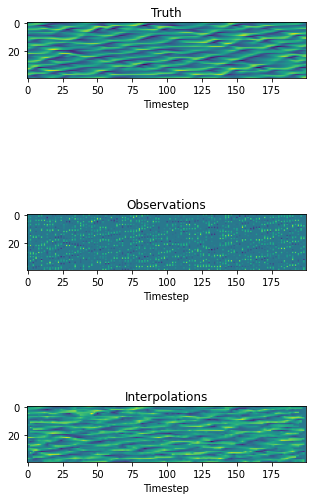

In [31]:
Training_dataset,Val_dataset,Test_dataset = L96PatchDataExtraction(sparsity=0.5,sigma_noise=np.sqrt(2),num_variables=40)


meanTe          = np.mean(Test_dataset['Missing']) / np.mean(Test_dataset['Mask']) 
stdTe           = np.sqrt( np.mean( Test_dataset['Missing']**2 ) / np.mean(Test_dataset['Mask']) )
visualisation_data96(Test_dataset['Truth'],Test_dataset['Obs'],Test_dataset['Init'],125)

In [48]:


class Int(torch.nn.Module):
    def __init__(self):
        super(Int, self).__init__()
        self.F         = torch.nn.Parameter(torch.Tensor([8.]))
        self.dt        = 0.05
        self.stdTe     = stdTe
        self.meanTe    = meanTe
             
    def _odeL96(self, xin):
        
        dx  = (xin[:,3:,:]-xin[:,0:xin.size(1)-3,:]) * xin[:,1:xin.size(1)-2,:] - xin[:,2:xin.size(1)-1,:]
        dx0 = (xin[:,1,:]-xin[:,xin.size(1)-2,:]) * xin[:,xin.size(1)-1,:] - xin[:,0,:]
        dx1 = (xin[:,2,:]-xin[:,xin.size(1)-1,:]) * xin[:,0,:] - xin[:,1,:]
        dxL = (xin[:,0,:]-xin[:,xin.size(1)-3,:]) * xin[:,xin.size(1)-2,:] - xin[:,xin.size(1)-1,:]
                            
        dx0 = dx0.view(-1,1,xin.size(2))
        dx1 = dx1.view(-1,1,xin.size(2))
        dxL = dxL.view(-1,1,xin.size(2))
        
        dpred = torch.cat((dx0,dx1,dx,dxL),dim=1) + self.F
        
        return dpred

    def _EulerSolver(self, x):
        return x + self.dt * self._odeL96(x)

      
    def forward(self, x):
        xpred = self._EulerSolver( x[:,:-1,:] )
        
        xnew  = torch.cat((x[:,0,:].view(-1,1,x.size(2)),xpred),dim=1)
        return xnew
    
modelInt      = Int()
    



In [ ]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelInt          = modelInt.to(device)
test_dataset         = torch.utils.data.TensorDataset(torch.Tensor(Test_dataset['Init']),torch.Tensor(Test_dataset['Obs']),torch.Tensor(Test_dataset['Mask']),torch.Tensor(Test_dataset['Truth'])) # create your datset
batch_size = 128
dataloaders = {
    'dataset': torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
}            
dataset_sizes = {'dataset': len(test_dataset)}

comptUpdate = 1
iterInit    = 0
iterStateUpdate = 250 
NIterGrad       = 25000
modIter         = 100
delta           = 1e4 
alpha           = 1e0* np.array([.01,0.99])

xhat_tot = []
numData  = 0
compt    = 0
for x_init,x_obs,masks,x_GT in dataloaders['dataset']:
    x_init    = x_init.to(device)
    x_obs     = x_obs.to(device)
    masks     = masks.to(device)
    x_GT      = x_GT.to(device)

    numData +=  x_GT.size(0)

    # initialisation
    xhat = x_init 
    xhat = torch.autograd.Variable(xhat, requires_grad=True)

    # 4DVar assimilation using trained gradient descent
    losses_test = []
    compt_kk = 0
    for kk in range(0,NIterGrad):     
        # AE projection
        x_pred = modelInt( xhat )
        
        # dynamical loss
        loss_dyn = torch.mean((xhat - x_pred)**2 )
    
        # observation loss
        loss_obs = torch.sum((xhat - x_obs)**2 * masks) / torch.sum( masks)
    
        ## loss wrt groudn-truth
        loss_GT  = torch.mean((xhat - x_GT)**2)

        # overall loss
        loss = alpha[0] * loss_obs + alpha[1] * loss_dyn 
    
        # compute gradient w.r.t. X and update X
        loss.backward()
        
        #grad_X  = torch.autograd.grad(loss,X_torch,create_graph=True)
        xhat = xhat - delta * xhat.grad.data
        xhat = torch.autograd.Variable(xhat, requires_grad=True)                                           
        # other loss types
        dB          = 0
        dT          = xhat.size(2)
        loss_R      = torch.sum( (xhat[:,:,dB:dT-dB] - x_GT[:,:,dB:dT-dB])**2 * masks[:,:,dB:dT-dB] )
        loss_R      = loss_R / torch.sum( masks[:,:,dB:dT-dB] )
        loss_AE_GT  = torch.mean( (modelInt(x_GT)[:,:,dB:dT-dB] - x_GT[:,:,dB:dT-dB])**2 )        
        loss_I      = torch.sum( (xhat[:,:,dB:dT-dB] - x_GT[:,:,dB:dT-dB])**2 * (1. - masks[:,:,dB:dT-dB]) )
        loss_I      = loss_I / torch.sum( (1. - masks[:,:,dB:dT-dB]) )

        # evaluate and store losses
        if( np.mod(kk,modIter) == 0 ):  
            # store as np
            if( compt_kk == 0 ):
                losses_test = torch.cat( (loss_GT.view(1,1),loss_dyn.view(1,1),loss_obs.view(1,1),loss_R.view(1,1),loss_I.view(1,1)), dim = 1 ).cpu().detach().numpy()                                
            else:
                losses_test = np.concatenate( (losses_test,torch.cat( (loss_GT.view(1,1),loss_dyn.view(1,1),loss_obs.view(1,1),loss_R.view(1,1),loss_I.view(1,1)), dim = 1 ).cpu().detach().numpy()) , axis = 0)
            compt_kk += 1
    xhat_tot.append(xhat)
    if compt == 0 :
        loss4DVar = x_GT.size(0) * losses_test
    else :
        loss4DVar = loss4DVar + x_GT.size(0) * losses_test
    compt += 1
    

loss4DVar = stdTr**2 * loss4DVar / numData
                            


2.4044998

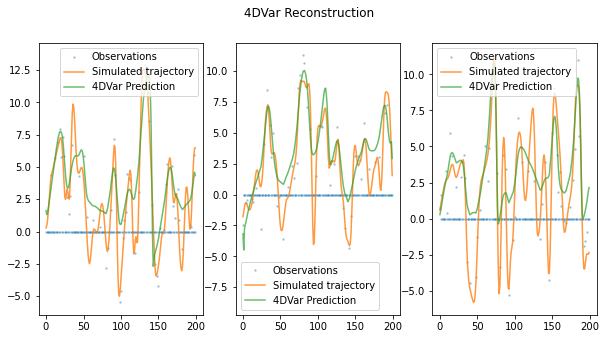

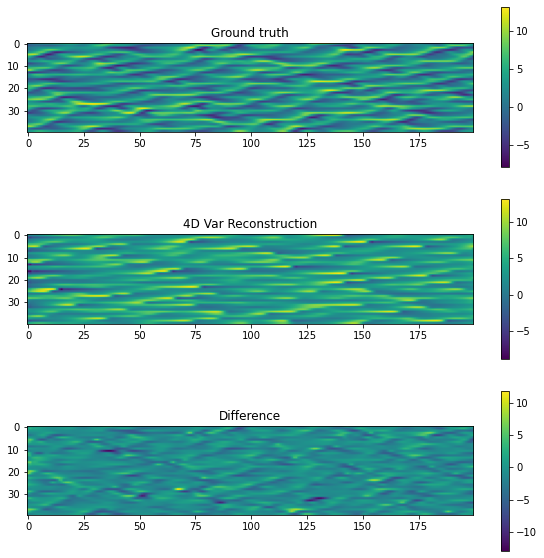

In [57]:
visualisation4DVar96(20,x_obs,x_GT,xhat)
reconstruction_error_4DVar96(x_GT,xhat)

# Learning AE model

In [0]:
batch_size = 64

#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_AE           = model_AE.to(device)

# mean-squared error loss
#criterion = torch.nn.MSELoss()
var_Tr    = np.var( x_train )
var_Tt    = np.var( x_test )

#### Check AE performance 
optimizer_AE       = optim.Adam(model_AE.parameters(), lr=1e-3)
exp_lr_schedulerAE = lr_scheduler.StepLR(optimizer_AE, step_size=100, gamma=0.1)

training_dataset     = torch.utils.data.TensorDataset(torch.Tensor(x_train_missing),torch.Tensor(x_train_obs),torch.Tensor(mask_train),torch.Tensor(x_train)) # create your datset
test_dataset         = torch.utils.data.TensorDataset(torch.Tensor(x_test_missing),torch.Tensor(x_test_obs),torch.Tensor(mask_test),torch.Tensor(x_test)) # create your datset

dataloaders = {
    'train': torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True),
    'val': torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True),
}

dataset_sizes = {'train': len(training_dataset), 'val': len(test_dataset)}

# training function for dinAE



In [0]:
since = time.time()

best_model_AE_wts = copy.deepcopy(model_AE.state_dict())
best_loss         = 1e10

num_epochs = 20
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
          model_AE.train()
        else:
          model_AE.eval()   # Set model to evaluate mode

        running_loss = 0.0
        num_loss     = 0

        # Iterate over data.
        #for inputs_ in dataloaders[phase]:
        #    inputs = inputs_[0].to(device)
        for inputs_init,inputs_missing,masks,targets_GT in dataloaders[phase]:
            targets_GT     = targets_GT.to(device)
            #print(inputs.size(0))

            # zero the parameter gradients
            optimizer_AE.zero_grad()

            # reshaping tensors
            targets_GT     = targets_GT.view(-1,1,targets_GT.size(1),targets_GT.size(2))

            # forward
            # need to evaluate grad/backward during the evaluation and training phase for model_AE
            with torch.set_grad_enabled(True): 
            #with torch.set_grad_enabled(phase == 'train'):
                outputs = model_AE(targets_GT)
                #outputs = model(inputs)
                #loss = criterion( outputs,  inputs)
                loss      = torch.mean((outputs - targets_GT)**2 )

                # backward + optimize only if in training phase
                if phase == 'train':
                  loss.backward()
                  optimizer_AE.step()

            # statistics
            running_loss             += loss.item() * inputs_missing.size(0)
            num_loss                 += inputs_missing.size(0)
            #running_expvar += torch.sum( (outputs - inputs)**2 ) / torch.sum(
        if phase == 'train':
            exp_lr_schedulerAE.step()

        epoch_loss       = running_loss / num_loss
        #epoch_acc = running_corrects.double() / dataset_sizes[phase]
        if phase == 'train':
          epoch_nloss = epoch_loss / var_Tr
        else:
          epoch_nloss = epoch_loss / var_Tt


        #print('{} Loss: {:.4f} '.format(
          #   phase, epoch_loss))
        print('{} Loss: {:.4e} NLossAll: {:.4e} '.format(
            phase, epoch_loss,epoch_nloss))

        # deep copy the model
        if phase == 'val' and epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model_wts = copy.deepcopy(model_AE.state_dict())

    print()

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
print('Best val loss: {:4f}'.format(best_loss))

Epoch 0/19
----------
train Loss: 6.4375e-07 NLossAll: 9.0868e-07 
val Loss: 6.6253e-07 NLossAll: 9.3307e-07 

Epoch 1/19
----------
train Loss: 5.7220e-07 NLossAll: 8.0767e-07 
val Loss: 6.5768e-07 NLossAll: 9.2623e-07 

Epoch 2/19
----------
train Loss: 5.6955e-07 NLossAll: 8.0394e-07 
val Loss: 6.5744e-07 NLossAll: 9.2589e-07 

Epoch 3/19
----------
train Loss: 5.6949e-07 NLossAll: 8.0385e-07 
val Loss: 6.5745e-07 NLossAll: 9.2590e-07 

Epoch 4/19
----------
train Loss: 5.6949e-07 NLossAll: 8.0386e-07 
val Loss: 6.5739e-07 NLossAll: 9.2583e-07 

Epoch 5/19
----------
train Loss: 5.6950e-07 NLossAll: 8.0387e-07 
val Loss: 6.5734e-07 NLossAll: 9.2575e-07 

Epoch 6/19
----------
train Loss: 5.6951e-07 NLossAll: 8.0389e-07 
val Loss: 6.5756e-07 NLossAll: 9.2606e-07 

Epoch 7/19
----------
train Loss: 5.6951e-07 NLossAll: 8.0389e-07 
val Loss: 6.5741e-07 NLossAll: 9.2585e-07 

Epoch 8/19
----------
train Loss: 5.6951e-07 NLossAll: 8.0389e-07 
val Loss: 6.5760e-07 NLossAll: 9.2612e-07 

E

# Learning AE/4DVar model from irregularly-sampled data (DinAE solver vs. gradient-based solver) using a fully groundtruthed dataset

In [32]:
# Force observed values to be maintained to be kept to the
# initial values (noise-free case): InterpFlag = True 
# vs. noisy case InterpFlag = False (default parameter)
InterpFlag = False
UsePriodicBoundary = True

#  use gpu if available
batch_size = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(".... Device GPU: "+str(torch.cuda.is_available()))
print(shapeData.shape)

# mean-squared error loss
#criterion = torch.nn.MSELoss()
var_Tr    = np.var( x_train )
var_Tt    = np.var( x_test )
              
alpha          = np.array([1.,0.1])
GradType       = 1 # Gradient computation (0: subgradient, 1: true gradient/autograd)
OptimType      = 2 # 0: fixed-step gradient descent, 1: ConvNet_step gradient descent, 2: LSTM-based descent
num_epochs     = 4000

IterUpdate     = [0,100,200,500,2000,1000,1200]#[0,2,4,6,9,15]
NbProjection   = [0,0,0,0,0,0,0]#[0,0,0,0,0,0]#[5,5,5,5,5]##
NbGradIter     = [10,10,20,20,20,20,20]#[0,0,1,2,3,3]#[0,2,2,4,5,5]#
lrUpdate       = [1e-3,1e-4,1e-4,1e-5,1e-5,1e-4,1e-5,1e-6,1e-7]

NBGradCurrent   = NbGradIter[0]
NBProjCurrent   = NbProjection[0]
lrCurrent       = lrUpdate[0]

model           = NN_4DVar.Model_4DVarNN_GradFP(model_AE,shapeData,NBProjCurrent,NBGradCurrent,GradType,OptimType,UsePriodicBoundary)        
modelSave       = NN_4DVar.Model_4DVarNN_GradFP(model_AE,shapeData,NBProjCurrent,NBGradCurrent,GradType,OptimType,UsePriodicBoundary) 
model           = model.to(device)
print('4DVar model: Number of trainable parameters = %d'%(sum(p.numel() for p in model.parameters() if p.requires_grad)))
              
flagLoadModel   = 0
#fileAEModelInit = ''
if flagLoadModel == 1:
    print('.... load model: '+fileAEModelInit)
    model.model_AE.load_state_dict(torch.load(fileAEModelInit))
    model.model_Grad.load_state_dict(torch.load(fileAEModelInit.replace('_modelAE_iter','_modelGrad_iter')))

# optimization setting: freeze or not the AE
lambda_LRAE = 0.5
optimizer   = optim.Adam([{'params': model.model_Grad.parameters()},
                        {'params': model.model_AE.encoder.parameters(), 'lr': lambda_LRAE*lrCurrent}
                        ], lr=lrCurrent)

# Create training/test data pytorch tensors and associated  
# list of tensors (xx[n][x] to access the nth sample for the xth field)
training_dataset     = torch.utils.data.TensorDataset(torch.Tensor(x_train_Init),torch.Tensor(x_train_obs),torch.Tensor(mask_train),torch.Tensor(x_train)) # create your datset
test_dataset         = torch.utils.data.TensorDataset(torch.Tensor(x_test_Init),torch.Tensor(x_test_obs),torch.Tensor(mask_test),torch.Tensor(x_test)) # create your datset

dataloaders = {
    'train': torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True),
    'val': torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True),
}            
dataset_sizes = {'train': len(training_dataset), 'val': len(test_dataset)}

# Suffix for file naming
genSuffixModelBase = genSuffixModel
    
genSuffixModel = genSuffixModelBase+'_DT'+str('%02d'%(time_step))+'_'+str('%03d'%(dT))
genSuffixModel = genSuffixModel+genSuffixObs
if lambda_LRAE == 0. :
      genSuffixModel = genSuffixModel+'_NoFTrAE'
    
genSuffixModel = genSuffixModel+'_Nproj'+str('%02d'%(NBProjCurrent))
genSuffixModel = genSuffixModel+'_Grad_'+str('%02d'%(GradType))+'_'+str('%02d'%(OptimType))+'_'+str('%02d'%(NBGradCurrent))


.... Device GPU: True
(3,)
Opitm type 2
Opitm type 2
4DVar model: Number of trainable parameters = 1117


In [0]:
# training function for dinAE
since = time.time()

alpha_Grad = alpha[0]
alpha_AE   = alpha[1]

best_model_wts = copy.deepcopy(model.state_dict())
best_loss = 1e10

num_epochs  = 3
comptUpdate = 1
iterInit    = 0
for epoch in range(iterInit,num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    if ( epoch == IterUpdate[comptUpdate] ) & ( epoch > 0 ):
        # update GradFP parameters
        NBProjCurrent = NbProjection[comptUpdate]
        NBGradCurrent = NbGradIter[comptUpdate]
        lrCurrent     = lrUpdate[comptUpdate]
        
        if( (NBProjCurrent != NbProjection[comptUpdate-1]) | (NBGradCurrent != NbGradIter[comptUpdate-1]) ):
            print("..... ")
            print("..... ")
            print("..... Update/initialize number of projections/Graditer in GradCOnvAE model # %d/%d"%(NbProjection[comptUpdate],NbGradIter[comptUpdate]))

            # update GradFP architectures
            print('..... Update model architecture')
            print("..... ")
            model = NN_4DVar.Model_4DVarNN_GradFP(model_AE,shapeData,NBProjCurrent,NBGradCurrent,GradType,OptimType,UsePriodicBoundary)        
            model = model.to(device)
            
            # copy model parameters from current model
            model.load_state_dict(best_model_wts)
            
            optimizer        = optim.Adam([{'params': model.model_Grad.parameters()},
                                    {'params': model.model_AE.encoder.parameters(), 'lr': lambda_LRAE*lrCurrent}
                                    ], lr=lrCurrent)

            # Suffix for file naming
            genSuffixModel = genSuffixModelBase+'_DT'+str('%02d'%(time_step))+'_'+str('%03d'%(dT))
            genSuffixModel = genSuffixModel+genSuffixObs
            if lambda_LRAE == 0. :
                  genSuffixModel = genSuffixModel+'_NoFTrAE'
            
            genSuffixModel = genSuffixModel+'_Nproj'+str('%02d'%(NBProjCurrent))
            genSuffixModel = genSuffixModel+'_Grad_'+str('%02d'%(GradType))+'_'+str('%02d'%(OptimType))+'_'+str('%02d'%(NBGradCurrent))

        else:
            # update optimizer learning rate
            print('..... Update learning rate')
            mm = 0
            lr = np.array([lrCurrent,lambda_LRAE*lrCurrent])
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr[mm]
                mm += 1

        # update counter
        if comptUpdate < len(IterUpdate)-1:
            comptUpdate += 1

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:        
        if phase == 'train':
            model.train()
        else:
            model.eval()
        #if phase == 'train':
        #    #rint('Learning')
        #    model.train()  # Set model to training mode
        #else:
        #    #print('Evaluation')
        #    model.eval()   # Set model to evaluate mode

        running_loss         = 0.0
        running_loss_All     = 0.
        running_loss_R       = 0.
        running_loss_I       = 0.
        running_loss_AE      = 0.
        num_loss             = 0

        # Iterate over data.
        #for inputs_ in dataloaders[phase]:
        #    inputs = inputs_[0].to(device)
        for inputs_init,inputs_missing,masks,targets_GT in dataloaders[phase]:
            inputs_init    = inputs_init.to(device)
            inputs_missing = inputs_missing.to(device)
            masks          = masks.to(device)
            targets_GT     = targets_GT.to(device)
            #print(inputs.size(0))


            # reshaping tensors
            inputs_init    = inputs_init.view(-1,1,inputs_init.size(1),inputs_init.size(2))
            inputs_missing = inputs_missing.view(-1,1,inputs_init.size(2),inputs_init.size(3))
            masks          = masks.view(-1,1,inputs_init.size(2),inputs_init.size(3))
            targets_GT     = targets_GT.view(-1,1,inputs_init.size(2),inputs_init.size(3))
                                    
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # need to evaluate grad/backward during the evaluation and training phase for model_AE
            with torch.set_grad_enabled(True): 
            #with torch.set_grad_enabled(phase == 'train'):
                inputs_init    = torch.autograd.Variable(inputs_init, requires_grad=True)
                if model.OptimType == 1:
                    outputs,grad_new,normgrad = model(inputs_init,inputs_missing,masks,None)
                    
                elif model.OptimType == 2:
                    outputs,hidden_new,cell_new,normgrad = model(inputs_init,inputs_missing,masks,None,None)
                    
                else:                               
                    outputs,normgrad = model(inputs_init,inputs_missing,masks)

                #outputs = model(inputs_init,inputs_missing,masks)
                
                loss_R      = torch.sum((outputs - targets_GT)**2 * masks )
                loss_R      = torch.mul(1.0 / torch.sum(masks),loss_R)
                loss_I      = torch.sum((outputs - targets_GT)**2 * (1. - masks) )
                loss_I      = torch.mul(1.0 / torch.sum(1.-masks),loss_I)
                loss_All    = torch.mean((outputs - targets_GT)**2 )
                loss_AE     = torch.mean((model.model_AE(outputs) - outputs)**2 )
                            
                loss_AE_GT  = torch.mean((model.model_AE(targets_GT) - targets_GT)**2 )
                #loss_AE_GT  = torch.mean((mod.model_AE(targets_GT) - targets_GT)**2 )

                loss  = alpha_Grad * loss_All + 0.5 * alpha_AE * ( loss_AE + loss_AE_GT )
                #if phase == 'train':                                 
                #    loss  = alpha_Grad * loss_All + 0.5 * alpha_AE * ( loss_AE + loss_AE_GT )
                #else:
                #    loss    = alpha_Grad * loss_R + alpha_AE * loss_AE

                # backward + optimize only if in training phase
                if( phase == 'train' ):
                    loss.backward()
                    optimizer.step()
                                
                # statistics
            running_loss             += loss.item() * inputs_missing.size(0)
            running_loss_I           += loss_I.item() * inputs_missing.size(0)
            running_loss_R           += loss_R.item() * inputs_missing.size(0)
            running_loss_All         += loss_All.item() * inputs_missing.size(0)
            running_loss_AE          += loss_AE_GT.item() * inputs_missing.size(0)
            num_loss                 += inputs_missing.size(0)

        epoch_loss       = running_loss / num_loss
        epoch_loss_All   = running_loss_All / num_loss
        epoch_loss_AE    = running_loss_AE / num_loss
        epoch_loss_I     = running_loss_I / num_loss
        epoch_loss_R     = running_loss_R / num_loss
        #epoch_acc = running_corrects.double() / dataset_sizes[phase]

        epoch_loss_All = epoch_loss_All * stdTr**2
        epoch_loss_I   = epoch_loss_I * stdTr**2
        epoch_loss_R   = epoch_loss_R * stdTr**2
        epoch_loss_AE  = epoch_loss_AE * stdTr**2

        print('{} Loss: {:.4e} NLossAll: {:.4e} NLossR: {:.4e} NLossI: {:.4e} NLossAE: {:.4e}'.format(
            phase, epoch_loss,epoch_loss_All,epoch_loss_R,epoch_loss_I,epoch_loss_AE),flush=True)
        #print('... F %f'%model.model_AE.encoder.F)
        
        # deep copy the model
        if phase == 'val' and epoch_loss < best_loss:
            best_loss      = epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
print('Best val loss: {:4f}'.format(best_loss))

Epoch 0/2
----------


# Evaluation of trained models

In [0]:


#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(".... Device GPU: "+str(torch.cuda.is_available()))

# mean-squared error loss
#criterion = torch.nn.MSELoss()
var_Tr    = np.var( x_train )
var_Tt    = np.var( x_test )
               
# Create training/test data pytorch tensors and associated  
# list of tensors (xx[n][x] to access the nth sample for the xth field)
training_dataset     = torch.utils.data.TensorDataset(torch.Tensor(x_train_Init),torch.Tensor(x_train_obs),torch.Tensor(mask_train),torch.Tensor(x_train)) # create your datset
test_dataset         = torch.utils.data.TensorDataset(torch.Tensor(x_test_Init),torch.Tensor(x_test_obs),torch.Tensor(mask_test),torch.Tensor(x_test)) # create your datset

dataloaders = {
    'train': torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True),
    'val': torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True),
}            
dataset_sizes = {'train': len(training_dataset), 'val': len(test_dataset)}


# training function for dinAE
# Each epoch has a training and validation phase
alpha4DVar = np.array([0.01,0.99])
y_train = np.zeros(x_train.shape)
y_test  = np.zeros(x_test.shape)

for phase in ['train', 'val']:        
    since = time.time()

    model.eval()
    #if phase == 'train':
    #    #rint('Learning')
    #    model.train()  # Set model to training mode
    #else:
    #    #print('Evaluation')
    #    model.eval()   # Set model to evaluate mode

    running_loss_Obs     = 0.0
    running_loss_All     = 0.
    running_loss_R       = 0.
    running_loss_I       = 0.
    running_loss_AE      = 0.
    running_loss_AE_GT   = 0.
    num_loss             = 0

    idx = 0 # counter

    # Iterate over data.
    #for inputs_ in dataloaders[phase]:
    #    inputs = inputs_[0].to(device)
    for inputs_init,inputs_missing,masks,targets_GT in dataloaders[phase]:
        inputs_init    = inputs_init.to(device)
        inputs_missing = inputs_missing.to(device)
        masks          = masks.to(device)
        targets_GT     = targets_GT.to(device)
        #print(inputs_init.size(0))


        # reshaping tensors
        inputs_init    = inputs_init.view(-1,1,inputs_init.size(1),inputs_init.size(2))
        inputs_missing = inputs_missing.view(-1,1,inputs_init.size(2),inputs_init.size(3))
        masks          = masks.view(-1,1,inputs_init.size(2),inputs_init.size(3))
        targets_GT     = targets_GT.view(-1,1,inputs_init.size(2),inputs_init.size(3))
                                
        # forward
        # need to evaluate grad/backward during the evaluation and training phase for model_AE
        with torch.set_grad_enabled(True): 
            #with torch.set_grad_enabled(phase == 'train'):
            inputs_init    = torch.autograd.Variable(inputs_init, requires_grad=True)
            if model.OptimType == 1:
                outputs,grad_new = model(inputs_init,inputs_missing,masks,None)
                
            elif model.OptimType == 2:
                outputs,hidden_new,cell_new = model(inputs_init,inputs_missing,masks,None,None)
                
            else:                               
                outputs = model(inputs_init,inputs_missing,masks)

            # store interpolation/reconstruction results
            if phase == 'train':
              y_train[idx:idx+inputs_missing.size(0),:,:] = outputs.cpu().detach().numpy().squeeze()
            else:
              y_test[idx:idx+inputs_missing.size(0),:,:]  = outputs.cpu().detach().numpy().squeeze()

            idx += inputs_missing.size(0)
            #outputs = model(inputs_init,inputs_missing,masks)
            
            loss_R      = torch.sum((outputs - targets_GT)**2 * masks ) / torch.sum(masks)
            loss_Obs    = torch.sum((outputs - inputs_missing)**2 * masks ) / torch.sum(masks)
            loss_I      = torch.sum((outputs - targets_GT)**2 * (1. - masks) ) / torch.sum(1.-masks)
            loss_All    = torch.mean((outputs - targets_GT)**2 )
            loss_AE     = torch.mean((model.model_AE(outputs) - outputs)**2 )

            loss_AE_GT  = torch.mean((model.model_AE(targets_GT) - targets_GT)**2 )
            #loss_AE_GT  = torch.mean((mod.model_AE(targets_GT) - targets_GT)**2 )

            #loss  = alpha_Grad * loss_All + 0.5 * alpha_AE * ( loss_AE + loss_AE_GT )
            #if phase == 'train':                                 
            #    loss  = alpha_Grad * loss_All + 0.5 * alpha_AE * ( loss_AE + loss_AE_GT )
            #else:
            #    loss    = alpha_Grad * loss_R + alpha_AE * loss_AE

            # backward + optimize only if in training phase
                            
        # statistics
        running_loss_I           += loss_I.item() * inputs_missing.size(0)
        running_loss_R           += loss_R.item() * inputs_missing.size(0)
        running_loss_Obs         += loss_Obs.item() * inputs_missing.size(0)
        running_loss_All         += loss_All.item() * inputs_missing.size(0)
        running_loss_AE_GT       += loss_AE_GT.item() * inputs_missing.size(0)
        running_loss_AE          += loss_AE.item() * inputs_missing.size(0)
        num_loss                 += inputs_missing.size(0)

    epoch_loss_All   = running_loss_All / num_loss
    epoch_loss_AE    = running_loss_AE / num_loss
    epoch_loss_AE_GT = running_loss_AE_GT / num_loss
    epoch_loss_I     = running_loss_I / num_loss
    epoch_loss_R     = running_loss_R / num_loss
    epoch_loss_Obs   = running_loss_Obs / num_loss
    #epoch_acc = running_corrects.double() / dataset_sizes[phase]

    epoch_loss_All   = epoch_loss_All * stdTr**2
    epoch_loss_I     = epoch_loss_I * stdTr**2
    epoch_loss_R     = epoch_loss_R * stdTr**2
    epoch_loss_Obs   = epoch_loss_Obs * stdTr**2
    epoch_loss_AE    = epoch_loss_AE * stdTr**2
    epoch_loss_AE_GT = epoch_loss_AE_GT * stdTr**2
    epoch_loss_4DVar = alpha4DVar[0] * epoch_loss_Obs + alpha4DVar[1] * epoch_loss_AE

    print('{} Loss4DVar: {:.4e} NLossObSGT: {:.4e} NLossR: {:.4e} NLossI: {:.4e} NLossAE: {:.4e} NLossAEGT: {:.4e}'.format(
        phase, epoch_loss_4DVar,epoch_loss_All,epoch_loss_R,epoch_loss_I,epoch_loss_AE,epoch_loss_AE_GT),flush=True)
        #print('... F %f'%model.model_AE.encoder.F)

    time_elapsed = time.time() - since
    print('Eval. time in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))



.... Device GPU: True
train Loss4DVar: 3.9863e-01 NLossObSGT: 1.8557e+00 NLossR: 2.0011e+00 NLossI: 1.8348e+00 NLossAE: 4.0265e-01 NLossAEGT: 1.7613e-02
Eval. time in 0m 19s
val Loss4DVar: 3.9686e-01 NLossObSGT: 1.7910e+00 NLossR: 2.0042e+00 NLossI: 1.7604e+00 NLossAE: 4.0087e-01 NLossAEGT: 1.7534e-02
Eval. time in 0m 3s


Text(0.5, 1.0, 'NN model 9.3715e-02')

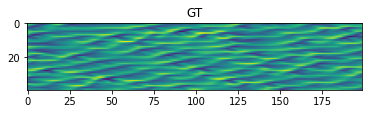

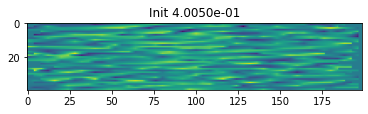

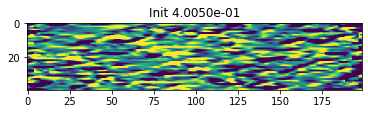

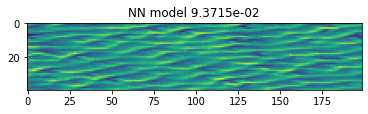

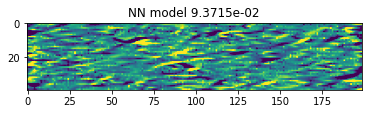

In [0]:
## Visualisation
idxTr = np.random.permutation(y_train.shape[0])[0:2]
idxTt = np.random.permutation(y_test.shape[0])[0:2]

plt.figure(1)
#plt.subplot(3,2,1)
plt.imshow(x_test[idxTt[0],:,:].squeeze())
plt.title('GT')

#plt.subplot(3,2,3)
plt.figure(2)
plt.imshow(x_test_Init[idxTt[0],:,:].squeeze())
plt.title('Init %.4e'%np.mean( (x_test_Init[idxTt[0],:,:]-x_test[idxTt[0],:,:])**2 ))

#plt.subplot(3,2,4)
plt.figure(3)
plt.imshow(x_test_Init[idxTt[0],:,:].squeeze()-x_test[idxTt[0],:,:].squeeze(),vmin=-0.5,vmax=0.5)
plt.title('Init %.4e'%np.mean( (x_test_Init[idxTt[0],:,:]-x_test[idxTt[0],:,:])**2 ))

#plt.subplot(3,2,5)
plt.figure(4)
plt.imshow(y_test[idxTt[0],:,:].squeeze())
plt.title('NN model %.4e'%np.mean( (y_test[idxTt[0],:,:]-x_test[idxTt[0],:,:])**2 ))

#plt.subplot(3,2,6)
plt.figure(5)
plt.imshow(y_test[idxTt[0],:,:].squeeze()-x_test[idxTt[0],:,:].squeeze(),vmin=-0.5,vmax=0.5)
plt.title('NN model %.4e'%np.mean( (y_test[idxTt[0],:,:]-x_test[idxTt[0],:,:])**2 ))



# 4DVar Assimilsation in pytorch

In [0]:
test_dataset         = torch.utils.data.TensorDataset(torch.Tensor(x_test_Init),torch.Tensor(x_test_obs),torch.Tensor(mask_test),torch.Tensor(x_test)) # create your datset

dataloaders = {
    'dataset': torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
}            
dataset_sizes = {'dataset': len(test_dataset)}

In [0]:
comptUpdate = 1
iterInit    = 0
iterStateUpdate = 250 
NIterGrad       = 20000
modIter         = 100
delta           = 1e4 
alpha           = 1e0* np.array([.01,0.99])

# Iterate over data.
#for inputs_ in dataloaders[phase]:
#    inputs = inputs_[0].to(device)

numData  = 0
compt    = 0
for x_init,x_obs,masks,x_GT in dataloaders['dataset']:
    x_init    = x_init.to(device)
    x_obs     = x_obs.to(device)
    masks     = masks.to(device)
    x_GT      = x_GT.to(device)

    numData +=  x_GT.size(0)

    # initialisation
    xhat = x_init 
    xhat = torch.autograd.Variable(xhat, requires_grad=True)

    # 4DVar assimilation using trained gradient descent
    losses_test = []
    compt_kk = 0
    for kk in range(0,NIterGrad):     
        # AE projection
        x_pred = model.model_AE( xhat )
        
        # dynamical loss
        loss_dyn = torch.mean((xhat - x_pred)**2 )
    
        # observation loss
        loss_obs = torch.sum((xhat - x_obs)**2 * masks) / torch.sum( masks)
    
        ## loss wrt groudn-truth
        loss_GT  = torch.mean((xhat - x_GT)**2)

        # overall loss
        loss = alpha[0] * loss_obs + alpha[1] * loss_dyn 
    
        # compute gradient w.r.t. X and update X
        loss.backward()
        
        #grad_X  = torch.autograd.grad(loss,X_torch,create_graph=True)
        xhat = xhat - delta * xhat.grad.data
        xhat = torch.autograd.Variable(xhat, requires_grad=True)
                                                          
        # other loss types
        dB          = 0
        dT          = xhat.size(2)
        loss_R      = torch.sum( (xhat[:,:,dB:dT-dB] - x_GT[:,:,dB:dT-dB])**2 * masks[:,:,dB:dT-dB] )
        loss_R      = loss_R / torch.sum( masks[:,:,dB:dT-dB] )
        loss_AE_GT  = torch.mean( (model.model_AE(x_GT)[:,:,dB:dT-dB] - x_GT[:,:,dB:dT-dB])**2 )        
        loss_I      = torch.sum( (xhat[:,:,dB:dT-dB] - x_GT[:,:,dB:dT-dB])**2 * (1. - masks[:,:,dB:dT-dB]) )
        loss_I      = loss_I / torch.sum( (1. - masks[:,:,dB:dT-dB]) )

        # evaluate and store losses
        if( np.mod(kk,modIter) == 0 ):  
            # store as np
            if( compt_kk == 0 ):
                losses_test = torch.cat( (loss_GT.view(1,1),loss_dyn.view(1,1),loss_obs.view(1,1),loss_R.view(1,1),loss_I.view(1,1)), dim = 1 ).cpu().detach().numpy()                                
            else:
                losses_test = np.concatenate( (losses_test,torch.cat( (loss_GT.view(1,1),loss_dyn.view(1,1),loss_obs.view(1,1),loss_R.view(1,1),loss_I.view(1,1)), dim = 1 ).cpu().detach().numpy()) , axis = 0)
            compt_kk += 1
    if compt == 0 :
        loss4DVar = x_GT.size(0) * losses_test
    else :
        loss4DVar = loss4DVar + x_GT.size(0) * losses_test
    compt += 1
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

loss4DVar = stdTr**2 * loss4DVar / numData
                            
print('..........................................')
print('.....')
print('.....')
print('')
for kk in range(0,loss4DVar.shape[0]):
    print('..... Loss Grad Descent %d:  GT %.6e   ---  dyn %.6e   ---  obs %.6e   ---  GT-R %.6e    ---  GT-I %.6e'%(kk*modIter,loss4DVar[kk,0],loss4DVar[kk,1],loss4DVar[kk,2],loss4DVar[kk,3],loss4DVar[kk,4]) )
